# Explainable AI con algoritmi genetici

Si mette il focus su problemi di classificazione o, per essere più precisi,
sui classificatori stessi.

Non è infatti di nostro interesse se la classificazione sia corretta o meno,
ci interessa sapere:

- "Perché" i dati sono stati classificati in quel modo.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

L'esempio più banale che può venirci in mente è un problema di classificazione
in cui ogni punto ha due sole feature e due possibili classi.


<Figure size 640x480 with 0 Axes>

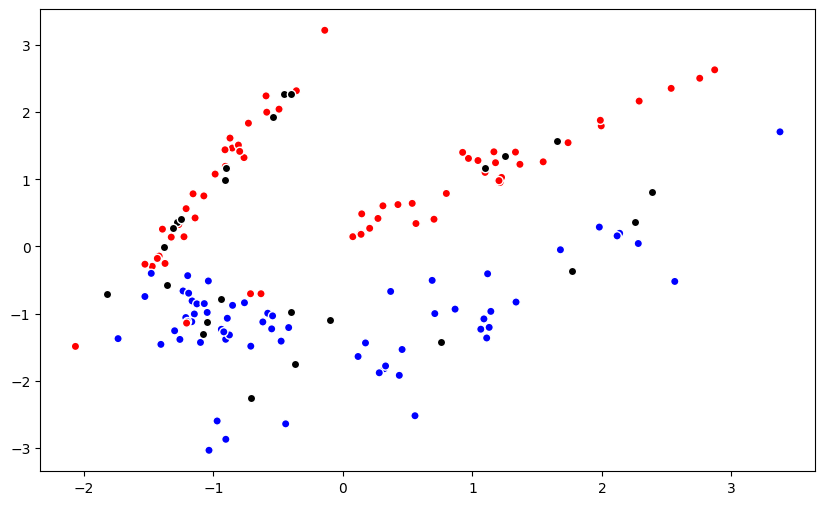

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X, y = make_classification(
    n_samples=150,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    shuffle=False,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=25, train_size=125)

plt.set_cmap("bwr")
plt.figure(figsize=(10, 6))
plt.scatter(X_train.T[0], X_train.T[1], c=y_train.T, ec="w")
plt.scatter(X_test.T[0], X_test.T[1], c="k", ec="w")
plt.show()

I punti blu e rossi ci servono ad allenare il modello, mentre i punti neri
sono quelli che useremo come test e che andremo a classificare in un secondo
momento.

Di seguito andiamo ad allenare un MLP e andiamo a classificare i punti neri.


Accuracy: 96.00%


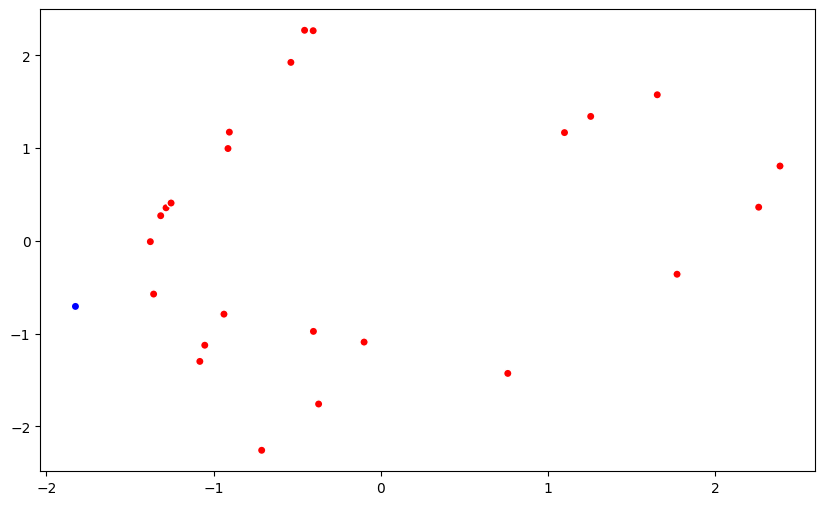

In [7]:
from sklearn.neural_network import MLPClassifier

import warnings

warnings.filterwarnings("ignore")

classifier = MLPClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test) == y_test
print(f"Accuracy: {y_predicted.sum() / len(y_test) * 100.0:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(X_test.T[0], X_test.T[1], c=y_predicted, ec="w")
plt.show()

## Algoritmo genetico

Nel caso specifico degli algoritmi genetici andiamo a trattare il problema
trattando i punti sintetici come la popolazione iniziale dell'algoritmo
genetico stesso.

### Stessa classe

Nel caso in cui si voglia capire come mai un certo individuo sia stato
classificiato in un certo modo, si fa evolvere la popolazione andando ad
attribuire

- Fitness più alta agli individui vicini a quello di partenza e che sono
  classificati allo stesso modo.
- Fitness più bassa ma comunque positiva ai fini dell'evoluzione per quegli
  individui più lontani ma comunque classificati allo stesso modo. In questo
  modo è possibile esplorare meglio lo spazio entro cui le feature possono
  variare senza che l'individuo venga classificato diversamente.
- Fitness bassa agli individui troppo diversi da quello di partenza.
- Fitness molto bassa o invalida a quelli che vengono classificati in modo
  diverso da quello di partenza.

In fase di valutazione di un individuo lo si deve per prima cosa classificare
e poi si va a calcolare la distanza dall'individuo di partenza.

Se l'individuo di partenza si trova molto vicino al confine tra una classe e
l'altra potrebbe succedere che si generi un individuo sintetico molto vicino
ma classificato in modo diverso. Ecco che diventa necessario studiare bene la
funzione di fitness di modo che si abbia una grossa penalità o che si invalidi
direttamente la fitness in questo caso.

### Cambio di classe

Nel caso in cui invece si voglia capire come modificare le feature per cambiare
la classe dell'individuo, si determina la classe obbiettivo e si cerca di
generare una popolazione la quale si evolve di modo da avvicinarsi il più
velocemente possibile a tale classe.

La funzione di fitness è dunque molto simile alla precedente ma usata in modo
quasi inverso.

- Gli individui con fitness più alta sono quelli che rimangono vicino a quello
  di partenza ma che riescono a cambiare classe.
- Quelli con fitness più bassa sono quelli che non riescono a cambiare classe
  e/o che sono troppo diversi dall'individuo di partenza.

Nel caso in cui si abbiamo più classi si ripete il procedimento per ognuna di
esse.
